<a href="https://colab.research.google.com/github/philipp-hellwig/evolution-language-simulation/blob/main/Bayesian_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Incomplete Information

As off now, the simulation was a white box for the agents: they had direct  access to other agents' reputations. However, this is an unrealistic assumption: In many cases, agents may not have direct access

In [63]:
import numpy as np
import warnings
from itertools import chain
import scipy.stats as st
import random

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.distributions as td
import seaborn as sns
from tqdm import tqdm

from IPython.display import display

from agents.base_agent import Agent


In [190]:
class BayesianAgent(Agent):
    id = 0
    laplace_smoothing = 0.0001

    def __init__(self, *args, **kwargs):
        super(BayesianAgent, self).__init__(*args, **kwargs)
        self.cohort = []
        self.beta_communicate = self.prior_communication
        self.beta_malintent = self.malintent
        self.id = BayesianAgent.id
        BayesianAgent.id += 1

    def calc_reputation(self):
        self.reputation = sum([other.beta_communicate[0] for other in self.cohort])
        
    def set_cohort(self, cohort: list):
        self.cohort = [agent for agent in cohort if agent is not self]
        smoothing = BayesianAgent.laplace_smoothing
        self.beta_communicate = {agent: [self.communication+smoothing, (len(self.dna)/6-self.communication)+smoothing] for agent in self.cohort}
        self.beta_malintent = {agent: [self.malintent+smoothing, (len(self.dna)/6-self.malintent)+smoothing] for agent in self.cohort}

    def likelihood_communicate(self, other):
        a, b = self.beta_communicate[other]
        return st.beta.rvs(a, b)
    
    def likelihood_malintent(self, other):
        a, b = self.beta_malintent[other]
        return st.beta.rvs(a, b)

    def plot_beta(self, other, type="both"):
        """
        other: another BayesianAgent
        
        output:
        graph for 
        """
        x = np.linspace(0,1,200)
        a, b = self.beta_communicate[other]
        _ = plt.plot(x, st.beta.pdf(x, a, b))
        _ = plt.xlabel("theta")
        _ = plt.ylabel("density")
        plt.show()
        
        
    # rewrite food opportunity interaction:
    def found_food(self, other):
        # decide to communicate or not:
        if st.bernoulli(self.likelihood_communicate(other)).rvs(1):
            # other also has to be willing to communicate
            if st.bernoulli(other.likelihood_communicate(self)).rvs(1):
                # decide to try to steal food or not
                if st.bernoulli(self.prior_malintent).rvs(1):
                    # other has good intentions:
                    if not st.bernoulli(other.prior_malintent).rvs(1):
                        self.food_counter += BayesianAgent.food_stealing
                        self.update_beta_communicate(other, positive_outcome=True)
                        other.update_beta_communicate(self, positive_outcome=False)
                    # if other also wants to steal the food:
                    else:
                        winner = np.random.choice([self, other])
                        loser = other if winner is self else self
                        winner.food_counter += BayesianAgent.food_stealing
                        winner.update_beta_communicate(loser, positive_outcome=True)
                        loser.update_beta_communicate(winner, positive_outcome=False)
                else:
                    if st.bernoulli(other.prior_malintent).rvs(1):
                        other.food_counter += BayesianAgent.food_stealing
                        other.update_beta_communicate(self, positive_outcome=True)
                        self.update_beta_communicate(other, positive_outcome=False)
                    else:
                        # share food:
                        self.food_counter += BayesianAgent.food_sharing
                        other.food_counter += BayesianAgent.food_sharing
                        self.update_beta_communicate(other, positive_outcome=True)
                        other.update_beta_communicate(self, positive_outcome=True)

            else:
                self.food_counter += BayesianAgent.food_individual_consumption
        else:
            self.food_counter += BayesianAgent.food_individual_consumption

    def update_beta_communicate(self, other, positive_outcome: bool):
        if positive_outcome:
            self.beta_communicate[other][0] += 1
        else:
            self.beta_communicate[other][1] += 1

    def gossip(self, other):
        if st.bernoulli(self.prior_communication).rvs(1):
            pass


## Bayesian iterative learning


[1.0001, 14.0001]


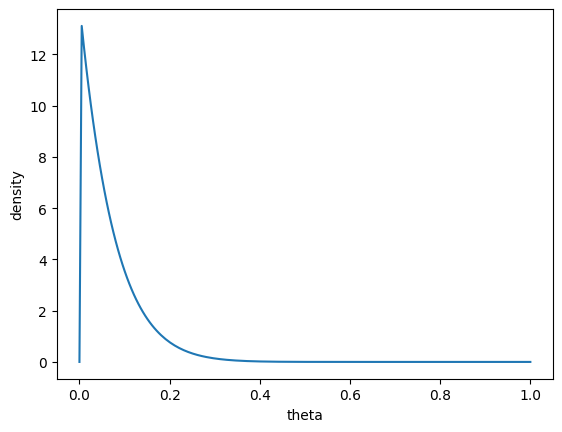

In [99]:
agents = [BayesianAgent(mu=0.01) for _ in range(10)]
for agent in agents:
    agent.set_cohort(agents)

# for example, the first agents parameters for the beta distribution to communicate with the second agent are:
print(agents[0].beta_communicate[agents[1]])

a, b = agents[0].beta_communicate[agents[1]]

beta_communicate = np.linspace(0,1,200)

This distribution gets updated anytime the first agent interacts with the second. For example, if they repeatedly interact positively:

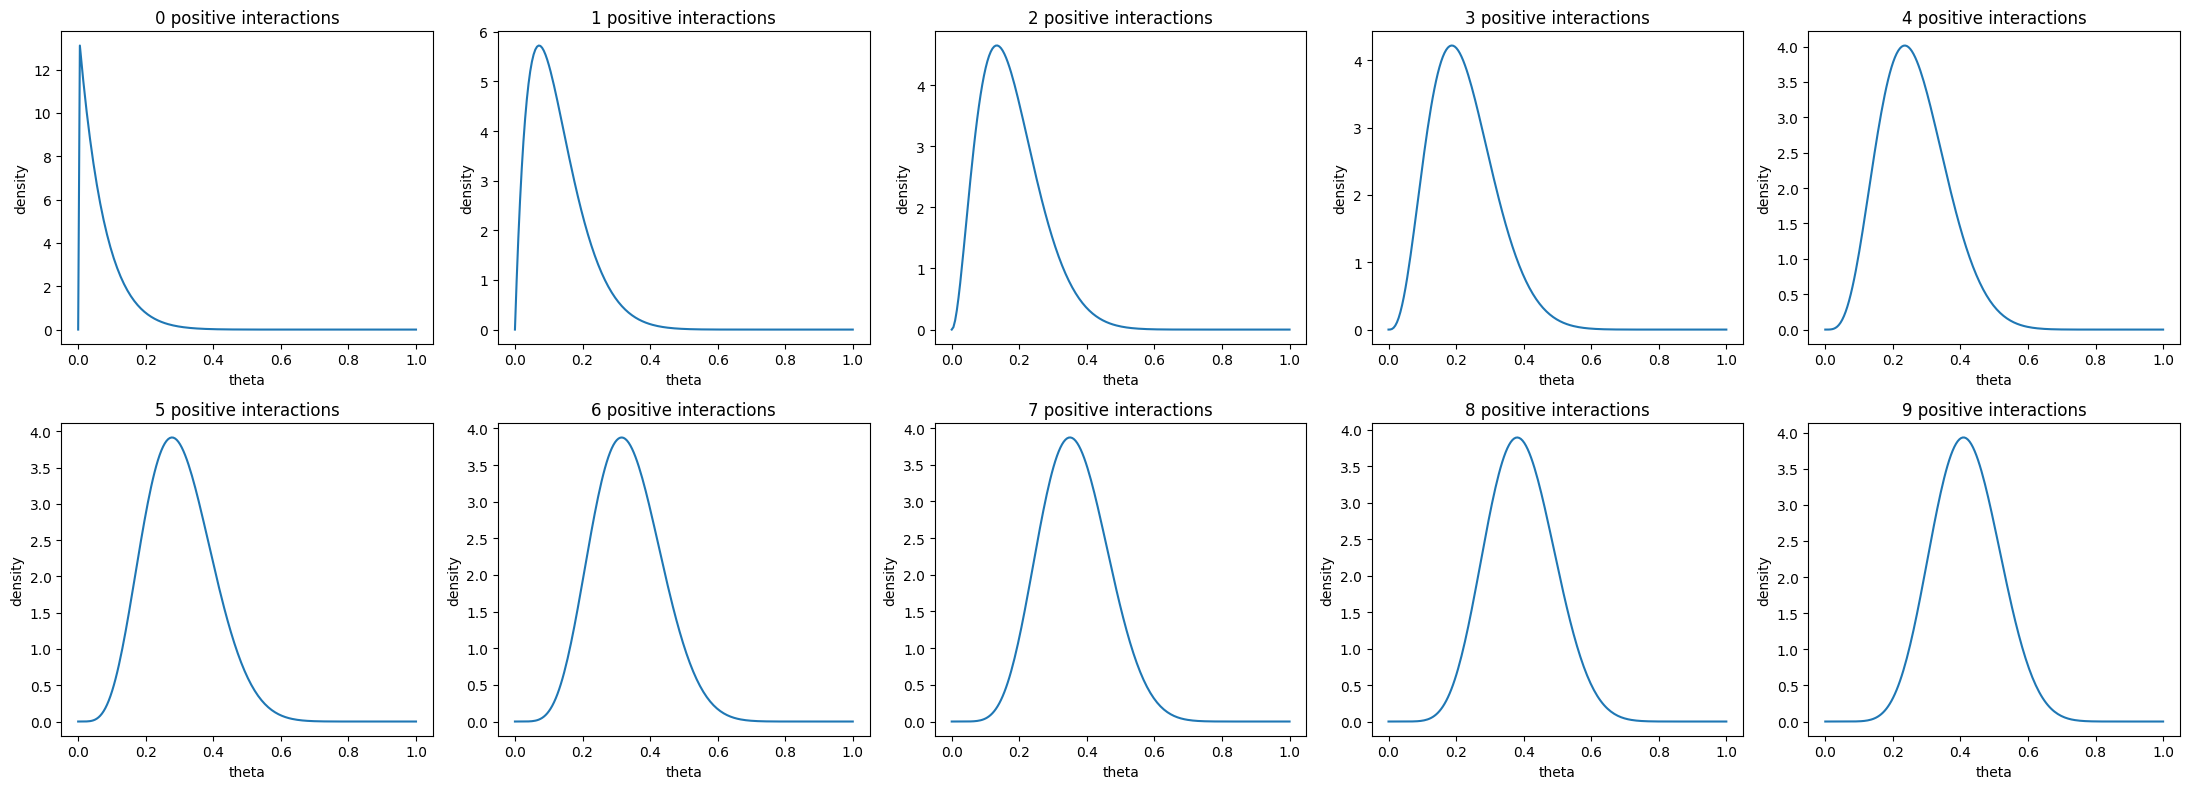

In [100]:
fig, ax = plt.subplots(2, 5, figsize = (22, 8))
for i in list(range(10)):
    a, b = agents[0].beta_communicate[agents[1]]
    _ = ax[int(i>4), i%5].plot(beta_communicate, st.beta.pdf(beta_communicate, a, b))
    _ = ax[int(i>4), i%5].set_xlabel("theta")
    _ = ax[int(i>4), i%5].set_ylabel("density")
    _ = ax[int(i>4), i%5].set_title(f"{i} positive interactions")

    agents[0].update_beta_communicate(agents[1], positive_outcome=True)
fig.tight_layout(w_pad=1, h_pad=1)

In [191]:
def normalize(values):
    """
    takes a list of positive numbers and adjusts them so they sum to 1
    """
    total = sum(values)
    return [value/total for value in values]

def reproduce(population: list[BayesianAgent], mu: float, reputation=False, size=1):
    offspring = []
    if len(population) > 2:
        for _ in range(size):
            for agent in population:
                agent.calc_reputation()
            reputations = normalize([agent.reputation for agent in population])
            repr_chances = td.Categorical(probs=torch.Tensor(reputations))
            parent1 = repr_chances.choice(population)[int(chosen_chances.sample())]
            
            positive_interactions = [(agent, parameters[0]) for agent, parameters in parent1.beta_communicate.items()]
            total_positive_interactions = sum([agent[1] for agent in positive_interactions])
            chosen_chances = td.Categorical(probs=torch.Tensor([agent[1]/total_positive_interactions for agent in positive_interactions]))
            parent2 = positive_interactions[int(chosen_chances.sample())][0]
            offspring.append(BayesianAgent(mu, parents=(parent1, parent2)))


def simulate_bayesian_agents(num_food_opportunities: int, num_generations:int, population_size:int, reputation_reproduction: bool, mu=0.01, **class_variables):
    # adjust class variables if given:
    Agent.set_class_variables(**class_variables)

    # set up df to collect data:
    features = pd.DataFrame(columns=["communication", "malintent", "starvation"])

    #initialize first generation
    current_gen = [BayesianAgent(mu) for _ in range(population_size)]
    

    for gen in tqdm(range(1, (num_generations+1))):
        for agent in current_gen:
            agent.set_cohort(current_gen)
        initial_generation_population_size = len(current_gen)
        for food_opportunity in range(1, (num_food_opportunities+1)):
            # apply food decay and food opportunities:
            for agent in current_gen:
                agent.apply_food_decay()
                agent.found_food(other=np.random.choice(agent.cohort))
            
            # starve agents every 5 generations if their food_counter drops too low:
            if food_opportunity % 5 == 0:
                current_gen = [agent for agent in current_gen if not agent.starve()]

        # record population level features/ statistics:
        communication, malintent = [],[]
        for agent in current_gen:
            communication.append(agent.communication)
            malintent.append(agent.malintent)
        features.loc[len(features.index)] = [
            np.mean(communication) if len(current_gen) > 0 else None,
            np.mean(malintent) if len(current_gen) > 0 else None,
            (initial_generation_population_size-len(current_gen)) if len(current_gen) > 0 else None,
            ]

        # simulate reproduction with reputation:
        if gen < num_generations:
            current_gen = reproduce(current_gen, mu, reputation=reputation_reproduction, size=population_size)
    return (current_gen, features)

def plot_simulation_stats(simulation_stats):
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    _ = sns.lineplot(data=simulation_stats.loc[:, simulation_stats.columns!="starvation"], ax=ax[0])
    _ = ax[0].set_xlabel("Generation")
    _ = ax[0].set_title("Features")
    _ = ax[0].set_ylim(0,17)
    _ = ax[1].scatter(simulation_stats.index, simulation_stats["starvation"], s=1)
    _ = ax[1].set_xlabel("Generation")
    _ = ax[1].set_title("Starvation")
    _ = ax[1].hlines(28, 0, len(simulation_stats), color="black", linestyles="dotted")
    _ = ax[1].legend(["starvation", "extinction threshold"])
    plt.show()


## First Simulation with Bayesian Agents

In [192]:
final_gen, sim_reputation = simulate_bayesian_agents(num_food_opportunities=100, num_generations=200, population_size=30, reputation_reproduction=True, food_decay=1.65)
plot_simulation_stats(sim_reputation)

  0%|          | 0/200 [00:01<?, ?it/s]


KeyError: 0

<Axes: >

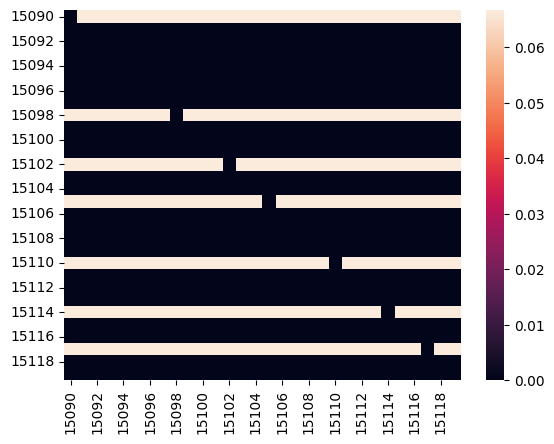

In [175]:
comm_matrix = pd.DataFrame(columns=[str(agent.id) for agent in final_gen])

for agent in final_gen:
    for other in final_gen:
        comm_matrix.loc[agent.id, str(other.id)] = agent.beta_communicate[other][0]/sum(agent.beta_communicate[other]) if agent is not other else 0.

comm_matrix = comm_matrix.apply(pd.to_numeric, errors='coerce')
comm_matrix.dtypes

_ = sns.heatmap(comm_matrix)

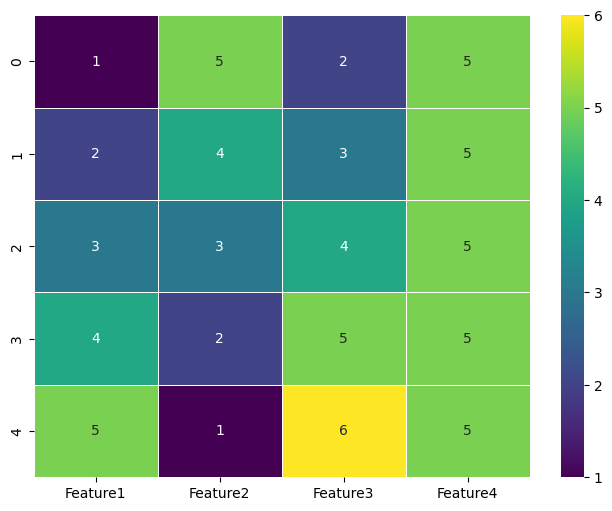

In [161]:
# Sample 2D data
data = {
    'Feature1': [1, 2, 3, 4, 5],
    'Feature2': [5, 4, 3, 2, 1],
    'Feature3': [2, 3, 4, 5, 6],
    'Feature4': [5, 5, 5, 5, 5]
}

df = pd.DataFrame(data)

# Set the size of the plot
plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(df, annot=True, cmap='viridis', linewidths=0.5)

# Display the heatmap
plt.show()

In [162]:
df

,Feature1,Feature2,Feature3,Feature4
0,1,5,2,5
1,2,4,3,5
2,3,3,4,5
3,4,2,5,5
4,5,1,6,5
